In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx
import matplotlib.pyplot as plt

In [5]:
rings_train = pd.read_csv('../data/classification/rings3-regular-training.csv')[['x', 'y', 'c']]
easy_train = pd.read_csv('../data/classification/easy-training.csv')[['x', 'y', 'c']]
xor3_train = pd.read_csv('../data/classification/xor3-training.csv')[['x', 'y', 'c']]

rings_test = pd.read_csv('../data/classification/rings3-regular-test.csv')[['x', 'y', 'c']]
easy_test = pd.read_csv('../data/classification/easy-test.csv')[['x', 'y', 'c']]
xor3_test = pd.read_csv('../data/classification/xor3-test.csv')[['x', 'y', 'c']]

rings_train_X = np.array(rings_train['x'])
rings_train_Y = np.array(rings_train['y'])
rings_train_C = np.array(rings_train['c'])

rings_test_X = np.array(rings_test['x'])
rings_test_Y = np.array(rings_test['y'])
rings_test_C = np.array(rings_test['c'])

easy_train_X = np.array(easy_train['x'])
easy_train_Y = np.array(easy_train['y'])
easy_train_C = np.array(easy_train['c'])

easy_test_X = np.array(easy_test['x'])
easy_test_Y = np.array(easy_test['y'])
easy_test_C = np.array(easy_test['c'])

xor3_train_X = np.array(xor3_train['x'])
xor3_train_Y = np.array(xor3_train['y'])
xor3_train_C = np.array(xor3_train['c'])

xor3_test_X = np.array(xor3_test['x'])
xor3_test_Y = np.array(xor3_test['y'])
xor3_test_C = np.array(xor3_test['c'])

easy_train size:  (500, 3) , test fmeasure goal: 0.99
rings_train size:  (1500, 3) , test fmeasure goal: 0.75
xor3_train size:  (500, 3) , test fmeasure goal: 0.97


<Axes: >

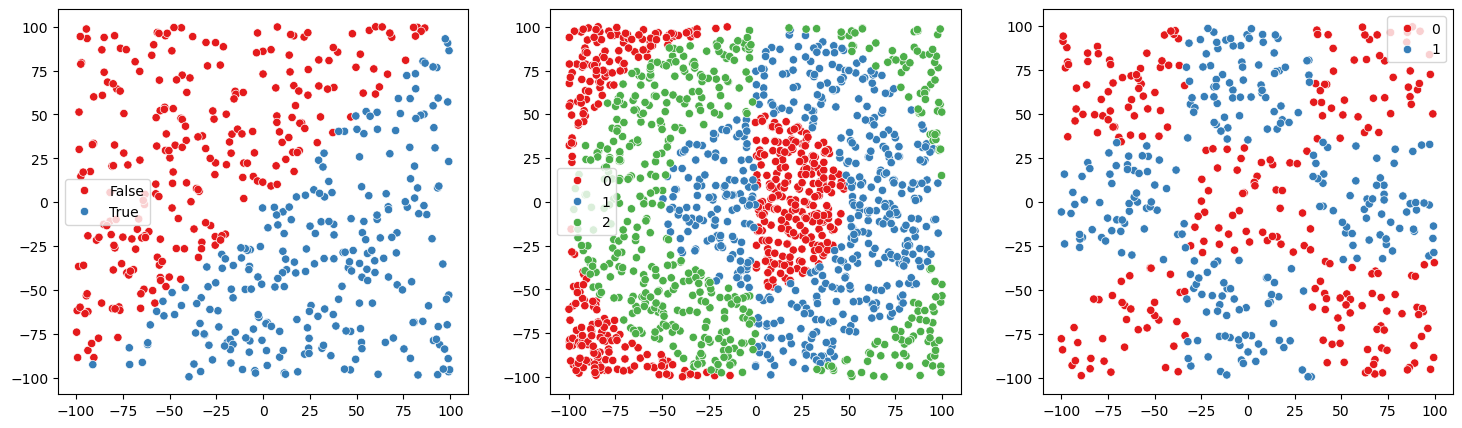

In [6]:
print('easy_train size: ', easy_train.shape, ', test fmeasure goal: 0.99')
print('rings_train size: ', rings_train.shape, ', test fmeasure goal: 0.75')
print('xor3_train size: ', xor3_train.shape, ', test fmeasure goal: 0.97')

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
sns.scatterplot(x=easy_train_X, y=easy_train_Y, hue=easy_train_C, ax=axes[0], palette='Set1')
sns.scatterplot(x=rings_train_X, y=rings_train_Y, hue=rings_train_C, ax=axes[1], palette='Set1')
sns.scatterplot(x=xor3_train_X, y=xor3_train_Y, hue=xor3_train_C, ax=axes[2], palette='Set1')

In [ ]:
def sigmoid(x):
	return 1/(1+np.e**(-x))

def sigmoid_derivative(x):
	return sigmoid(x) * (1 - sigmoid(x))

def linear(x):
	return x

def linear_derivative(x):
	return 1

def softmax(x):
    if x.ndim == 1:
        x = x.reshape(1, -1)  
    
    e_x = np.exp(x - np.max(x, axis=1, keepdims=True))
    return e_x / np.sum(e_x, axis=1, keepdims=True)

class network:
	def __init__(self, architecture, activation_functions, activation_derivatives, initiation_method):
		self.architecture = architecture
		self.activation_functions = activation_functions
		self.activation_derivatives = activation_derivatives
		self.weights_biases_initiation(initiation_method)
		self.loss_record = []
		self.f1_score = []

	def set_state(self, architecture, biases, weights, activation_functions):
		self.architecture = architecture
		self.biases = biases
		self.weights = weights
		self.activation_functions = activation_functions

	def weights_biases_initiation(self, initiation_method):
		self.weights = [None]
		self.biases = [None]
		self.weights_momentum = [None]
		self.biases_momentum = [None]
		self.weigths_rmsProp = [None]
		self.biases_rmsProp = [None]

		if initiation_method not in ['he', 'xavier', 'uniform']:
			print('Initiation method incorrect!')
			return 

		for i in range(len(self.architecture) - 1):
			input_dim = self.architecture[i]
			output_dim = self.architecture[i + 1]
			
			if initiation_method == 'he':
				weight_matrix = np.random.randn(input_dim, output_dim) * np.sqrt(2 / input_dim)
			elif initiation_method == 'xavier':
				weight_matrix = np.random.randn(input_dim, output_dim) * np.sqrt(1 / input_dim)
			elif initiation_method == 'uniform':
				weight_matrix = np.random.uniform(0, 1, (input_dim, output_dim))

			bias_vector = np.zeros((1, output_dim))
			
			self.weights_momentum.append(np.zeros(weight_matrix.shape))
			self.biases_momentum.append(np.zeros(bias_vector.shape))
			self.weigths_rmsProp.append(np.zeros(weight_matrix.shape))
			self.biases_rmsProp.append(np.zeros(bias_vector.shape))
			self.weights.append(weight_matrix)
			self.biases.append(bias_vector)

	def forward(self, X):
		# as a convention, for convinience, zeroth index of activations is raw input, i add None to preactivations for uniform indexing
		self.activations = [X]
		self.preactivations = [None]

		for i in range(0, len(self.architecture)-1):
			z = np.dot(self.activations[i], self.weights[i+1]) + self.biases[i+1]
			self.preactivations.append(z)
			
			a = self.activation_functions[i+1](z)
			self.activations.append(a)
	
	def check_MSE(self, x, y):
		self.forward(x)
		prediction = self.destandardize_data(self.activations[-1], 'y')
		correct = self.destandardize_data(y, 'y')
		return np.mean((correct - prediction) ** 2)
	
	def check_categorical_crossentropy_loss(self, x, y, epsilon=1e-12):
		self.forward(x)
		prediction = self.activations[-1]
		prediction = np.clip(prediction, epsilon, 1.0 - epsilon)
		loss = -np.sum(y * np.log(prediction), axis=1)
		return np.mean(loss)

	def check_fmeasure(self, x, y):
		self.forward(x)
		prediction = np.argmax(self.activations[-1], axis=1)
		correct = np.argmax(y, axis=1)

		labels = np.unique(y)

		true_positives = np.zeros(len(labels))
		false_positives = np.zeros(len(labels))
		false_negatives = np.zeros(len(labels))

		for i, label in enumerate(labels):
			true_positives[i] = np.sum((prediction == label) & (correct == label))
			false_positives[i] = np.sum((prediction == label) & (correct != label))
			false_negatives[i] = np.sum((prediction != label) & (correct == label))

		precision = true_positives / (true_positives+false_positives + 1e-10)
		recall = true_positives / (true_positives+false_negatives + 1e-10)

		f1_per_class = 2 * (precision * recall) / (precision + recall + 1e-10)
		return np.mean(f1_per_class)
	
	def visualize_network(self):
		G = nx.DiGraph()
		pos = {}
		edge_colors = []
		edge_widths = []
		
		for layer_idx, num_nodes in enumerate(self.architecture):
			for node_idx in range(num_nodes):
				node_name = f"L{layer_idx}_N{node_idx}"
				pos[node_name] = (layer_idx, -node_idx)  
				G.add_node(node_name)
				
				if layer_idx > 0: 
					for prev_idx in range(self.architecture[layer_idx - 1]):
						prev_name = f"L{layer_idx-1}_N{prev_idx}"
						weight = self.weights[layer_idx][prev_idx][node_idx]

						if weight != 0:
							G.add_edge(prev_name, node_name)
							edge_colors.append('red' if weight < 0 else 'green')
							edge_widths.append(np.log(abs(weight)))
		
		plt.figure(figsize=(10, 5))
		nx.draw(G, pos, with_labels=True, node_size=700, node_color="skyblue", edge_color=edge_colors, width=edge_widths)
		plt.show()

	def backward(self, Y, task):
		self.error = [None] * (len(self.weights))
		self.weights_gradient = [None] * (len(self.weights))
		self.biases_gradient = [None] * (len(self.weights))

		# if task == 'regression':
		# 	self.error[-1] = (self.activations[-1] - Y) * self.activation_derivatives[-1](self.preactivations[-1])
		# if task == 'classification':
		# 	self.error[-1] = (self.activations[-1] - Y)
		
		# normalnie to to kwestia czy regresja czy klasyfikacja ale żeby spróbować klasyfikacji dla liniowej ostatniej warstywy robie tak 
		if self.activation_functions[-1] != softmax: 
			self.error[-1] = (self.activations[-1] - Y) * self.activation_derivatives[-1](self.preactivations[-1])
		else:
			self.error[-1] = (self.activations[-1] - Y)

		for i in reversed(range(1, len(self.error) - 1)):
			self.error[i] = np.dot(self.error[i+1], self.weights[i+1].T) * self.activation_derivatives[i](self.preactivations[i])
		
		for i in range(1, len(self.error)):
			# self.weights_gradient[i] = -step * np.dot(self.activations[i-1].T, self.error[i]) / self.error[i].shape[0]
			# self.biases_gradient[i] = (-step * np.mean(self.error[i], axis=0)).reshape(1, -1)
			self.weights_gradient[i] = np.dot(self.activations[i-1].T, self.error[i]) / self.error[i].shape[0]
			self.biases_gradient[i] = (np.mean(self.error[i], axis=0)).reshape(1, -1)

	def prepeare_batches(self, x, y, task, batch_size=None):
			n = len(x)
			if batch_size == None:
				batch_number = 1
			else:
				batch_number = int(np.ceil(n / batch_size))

			indices = np.random.permutation(n)
			x_shuffled = x[indices]
			y_shuffled = y[indices]

			x_batched = np.array_split(x_shuffled, batch_number)
			y_batched = np.array_split(y_shuffled, batch_number)

			return x_batched, y_batched, batch_number
		
	def prepare_data(self, x, y, task):
		input_size = len(x)
		
		for i in range(input_size):
			size = len(x[i])
			x[i] = np.reshape(x[i], (size, 1))
		
		x = np.hstack(x)
		y = np.reshape(y, (len(y), 1))

		x_standardized = self.standardize_data(x, 'x')

		if task == 'classification':
			labels = np.unique(y)
			label_to_index = {label: index for index, label in enumerate(labels)}
			indexes = np.array([label_to_index[label] for label in y.flatten()])

			labels_num = len(labels)
			y = np.eye(labels_num)[indexes]

			return x_standardized, y
		else:
			y_standardized = self.standardize_data(y, 'y')

			return x_standardized, y_standardized
	
	def learn_old(self, x, y, step, iterations):
		x = self.standardize_data(x, 'x')
		y = self.standardize_data(y, 'y')

		for e in range(iterations):
			self.forward(x)
			self.backward(y, step)
			
			for i in range(1, len(self.architecture)):
					self.weights[i] += self.weights_gradient[i]
					self.biases[i] += self.biases_gradient[i]

			self.mse_record.append(self.check_MSE(x, y))

	def learn(self, task, x, y, epochs_number, step, momentum_dumping=None, rmsprop_dumping=None, batch_size=None):
		if momentum_dumping != None and rmsprop_dumping != None:
			print('Both momentum and rmsProp parameters were passed! Choose one.')
			return 
		
		if task not in ['classification', 'regression']:
			print('Incorrect network task! Choose classification or regression.')
			return
		
		x, y = self.prepare_data(x, y, task)
		
		for e in range(epochs_number):
			x_batches, y_batches, batch_number = self.prepeare_batches(x, y, task, batch_size)

			for b in range(batch_number):
				self.forward(x_batches[b])
				self.backward(y_batches[b], task)

				for i in range(1, len(self.architecture)):
					if momentum_dumping == None and rmsprop_dumping == None:
						# simple learning
						self.weights[i] -= self.weights_gradient[i] * step
						self.biases[i] -= self.biases_gradient[i] * step

					elif momentum_dumping != None and rmsprop_dumping == None:
						# learning with momentum
						self.weights_momentum[i] = self.weights_momentum[i] * momentum_dumping - self.weights_gradient[i]
						self.biases_momentum[i] = self.biases_momentum[i] * momentum_dumping - self.biases_gradient[i]
						self.weights[i] += self.weights_momentum[i] * step
						self.biases[i] += self.biases_momentum[i] * step

					elif momentum_dumping == None and rmsprop_dumping != None:
						# learning with rmsProp
						epsilon = 1e-8
						self.weigths_rmsProp[i] = rmsprop_dumping * self.weigths_rmsProp[i] + (1 - rmsprop_dumping) * self.weights_gradient[i]**2
						self.biases_rmsProp[i] = rmsprop_dumping * self.biases_rmsProp[i] + (1 - rmsprop_dumping) * self.biases_gradient[i]**2
						self.weights[i] -= step/(np.sqrt(self.weigths_rmsProp[i] + epsilon)) * self.weights_gradient[i]
						self.biases[i] -= step/(np.sqrt(self.biases_rmsProp[i] + epsilon)) * self.biases_gradient[i]

			if task == 'regression':
				self.loss_record.append(self.check_MSE(np.vstack(x_batches), np.vstack(y_batches)))
			if task == 'classification':
				self.loss_record.append(self.check_categorical_crossentropy_loss(np.vstack(x_batches), np.vstack(y_batches)))
				self.f1_score.append(self.check_fmeasure(np.vstack(x_batches), np.vstack(y_batches)))

	def standardize_data(self, data, type):
		mean = np.mean(data, axis=0)
		std = np.std(data, axis=0)
		data_new = (data - mean) / std

		if type == 'x':
			self.standardize_params_x = (mean, std)
		if type == 'y':
			self.standardize_params_y = (mean, std)

		return data_new

	def destandardize_data(self, data, type):
		if type == 'x':
			return data * self.standardize_params_x[1] + self.standardize_params_x[0]
		if type == 'y':
			return data * self.standardize_params_y[1] + self.standardize_params_y[0]

def test_regression(x, y, size, network):
	x = x.reshape(size, 1)
	y = y.reshape(size, 1)
	x_std = (x - network.standardize_params_x[0]) / network.standardize_params_x[1]
	
	network.forward(x_std)
	y_pred_std = network.activations[-1]
	y_pred = network.destandardize_data(y_pred_std, 'y')

	print('test mse:', np.mean((y - y_pred) ** 2))
	sns.scatterplot(x=x.flatten(), y=y_pred.flatten(), alpha=0.8, label='Predicted')
	sns.scatterplot(x=x.flatten(), y=y.flatten(), alpha=0.8, label='Actual')

def test_classification(x, y, network):
	task = 'classification'

	x_prep, y_prep = network.prepare_data(x, y, task)

	print('test cross entropy:', network.check_categorical_crossentropy_loss(x_prep, y_prep))
	print('test f-measure:', network.check_fmeasure(x_prep, y_prep))
	classification = np.argmax(network.activations[-1], axis=1)

	fig, axes = plt.subplots(1, 2, figsize=(12, 5))
	sns.scatterplot(x=x[0].flatten(), y=x[1].flatten(), hue=classification, ax=axes[0], palette='Set1')
	axes[0].set_title("Predicted Classification")
	sns.scatterplot(x=x[0].flatten(), y=x[1].flatten(), hue=y.flatten(), ax=axes[1], palette='Set1')
	axes[1].set_title("True Classification")

In [ ]:
# zbiór easy
# faktycznie jest easy, na treningowym bardzo szybko można osiągnąć 0.999... f-score ale żeby wstrzelić się w wynik ponad 0.99 na testowym to trochę ruletka, 0.985.. udało mi się najwięcej

Final f1_score:  0.9839999999496064
Final loss score:  0.17821801410103322
test cross entropy: 0.17208861568764924
test f-measure: 0.9839907786381437


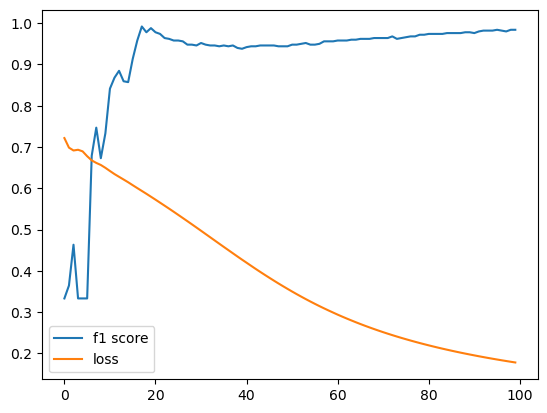

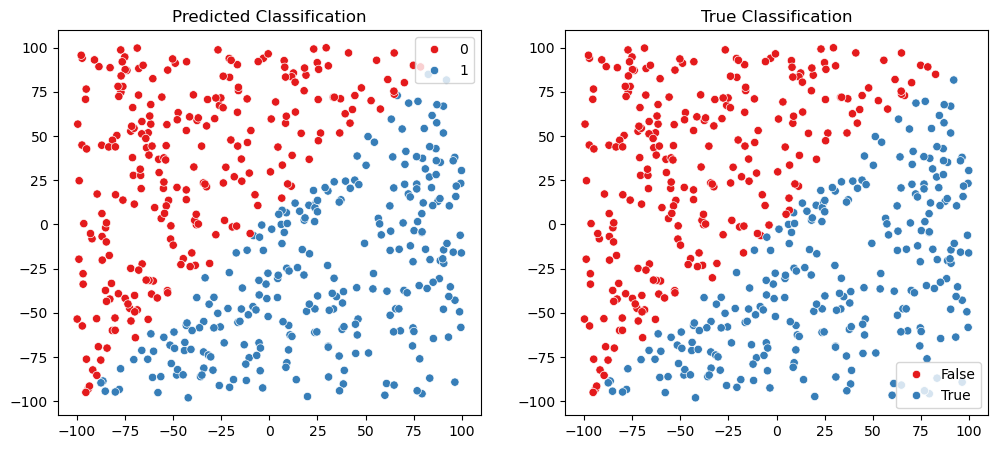

In [328]:
network_simple = network(architecture = np.array([2, 32, 32, 2]), 
                        activation_functions = [None, sigmoid, sigmoid, softmax], 
                        activation_derivatives = [None, sigmoid_derivative, sigmoid_derivative, None], 
                        initiation_method = 'xavier')

network_simple.learn(task = 'classification',
                     x = [easy_train_X, easy_train_Y],
                     y = easy_train_C,
                     epochs_number = 100,
                     step = 0.01,
                     momentum_dumping = 0.90,
                     batch_size = 200)

print('Final f1_score: ', network_simple.f1_score[-1])
print('Final loss score: ', network_simple.loss_record[-1])
sns.lineplot(network_simple.f1_score, label = 'f1 score')
sns.lineplot(network_simple.loss_record, label = 'loss')

test_classification([easy_test_X, easy_test_Y], easy_test_C, network_simple)

In [ ]:
# zbiór rings
# bardzo ciekawy zbiorek, ale wcale nie trudniejszy dużo, epok wciąż mało a 0.75 f-score na testowym bez najmniejszych problemów

Final f1_score:  0.980473459381179
Final loss score:  0.07279187089384906
test cross entropy: 0.17653469241199676
test f-measure: 0.9202076124066241


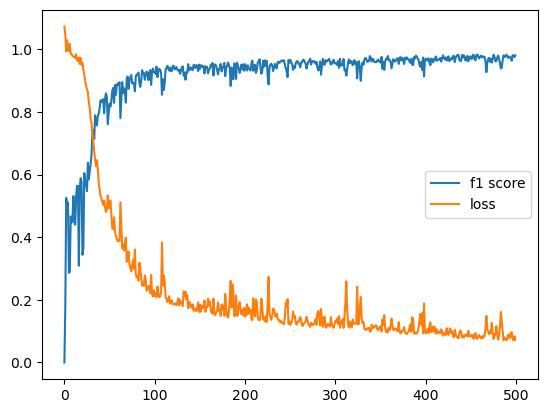

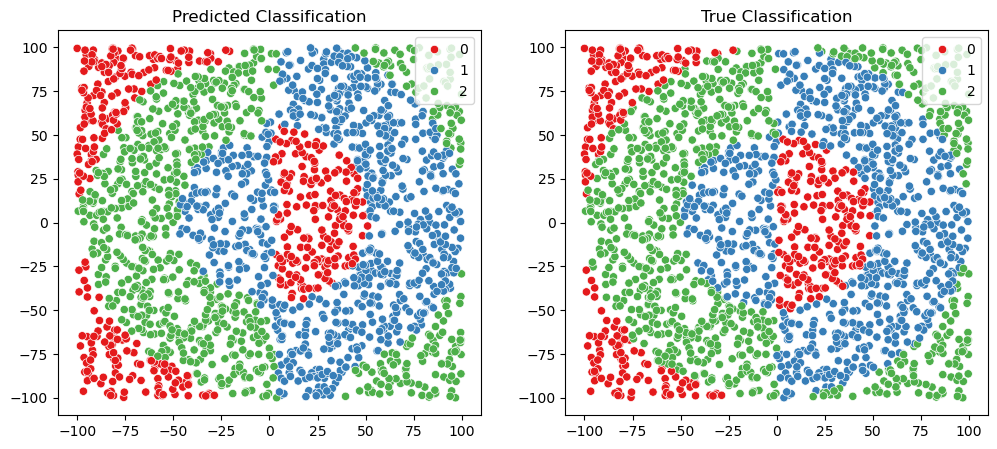

In [299]:
network_rings = network(architecture = np.array([2, 64, 64, 3]), 
                        activation_functions = [None, sigmoid, sigmoid, softmax], 
                        activation_derivatives = [None, sigmoid_derivative, sigmoid_derivative, None], 
                        initiation_method = 'xavier')

network_rings.learn(task = 'classification',
                     x = [rings_train_X, rings_train_Y],
                     y = rings_train_C,
                     epochs_number = 500,
                     step = 0.1,
                     momentum_dumping = 0.9,
                     batch_size = 150)

print('Final f1_score: ', network_rings.f1_score[-1])
print('Final loss score: ', network_rings.loss_record[-1])
sns.lineplot(network_rings.f1_score, label = 'f1 score')
sns.lineplot(network_rings.loss_record, label = 'loss')

test_classification([rings_test_X, rings_test_Y], rings_test_C, network_rings)

In [ ]:
# zbiór xor3
# zdecydowanie najgorszy case, najlepszy f-score na teście jaki widziałem to okolice 0.91, ciężko szukać przy ilu epokach jeszcze się nie przetrenowuje, bo wyniki (przy jednakowych parametrach) są chyba najbardziej zmienne ze wszystkich zbiorów

Final f1_score:  0.9819941660594429
Final loss score:  0.06302921369760926
test cross entropy: 0.21080199128067953
test f-measure: 0.9059397032098839


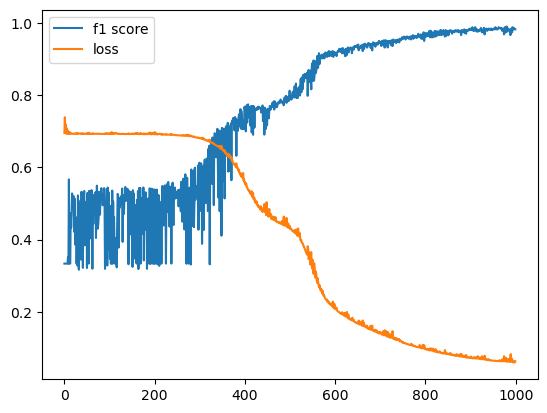

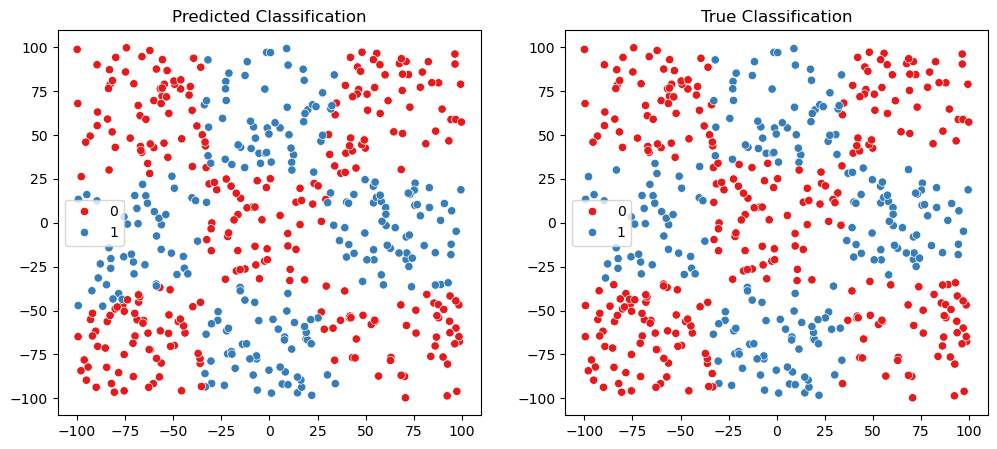

In [349]:
network_xor3 = network(architecture = np.array([2, 30, 30, 2]), 
                        activation_functions = [None, sigmoid, sigmoid, softmax], 
                        activation_derivatives = [None, sigmoid_derivative, sigmoid_derivative, None], 
                        initiation_method = 'xavier')

network_xor3.learn(task = 'classification',
                     x = [xor3_train_X, xor3_train_Y],
                     y = xor3_train_C,
                     epochs_number = 1000,
                     step = 0.05,
                     momentum_dumping = 0.95,
                     batch_size = 200)

print('Final f1_score: ', network_xor3.f1_score[-1])
print('Final loss score: ', network_xor3.loss_record[-1])
sns.lineplot(network_xor3.f1_score, label = 'f1 score')
sns.lineplot(network_xor3.loss_record, label = 'loss')

test_classification([xor3_test_X, xor3_test_Y], xor3_test_C, network_xor3)

In [ ]:
# poniżej próba tego samego ale z liniową aktywacją na końcu sieci
# no i radzi sobie świetnie, przy tych samych parametrach, być może te zadania klasyfikacji nie są jeszcze aż tak wygórowane, w tych wydrukach gdzie jest napisane cross entropy powinno być oczywiście mse  

Final f1_score:  0.96599877590555
Final loss score:  0.2605184170074234
test cross entropy: 0.2525994161443775
test f-measure: 0.9639717538046566


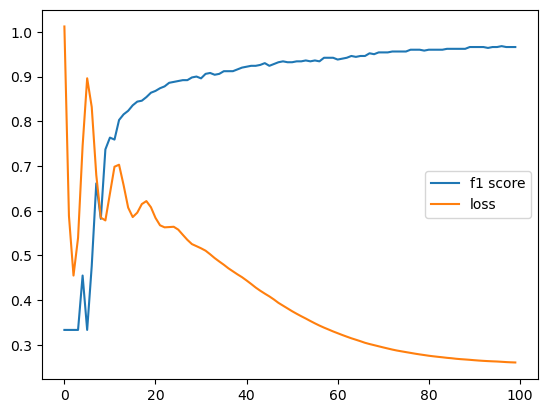

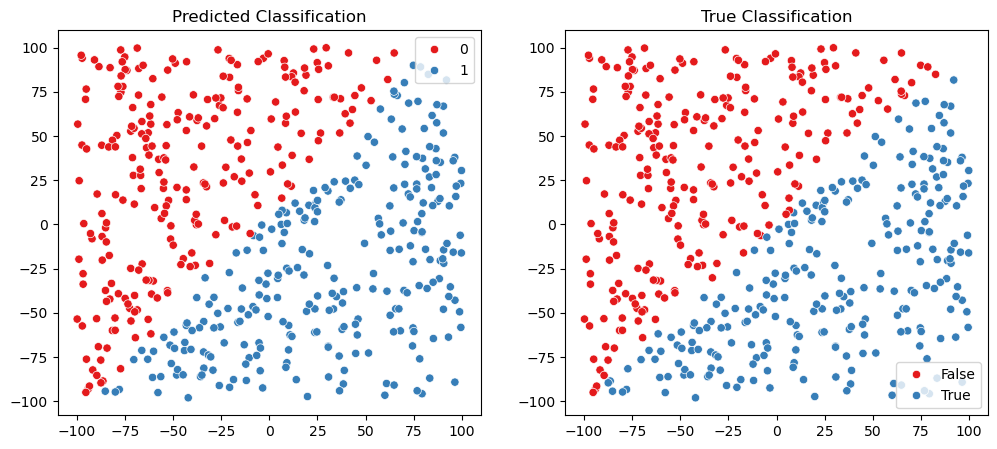

In [11]:
network_simple = network(architecture = np.array([2, 32, 32, 2]), 
                        activation_functions = [None, sigmoid, sigmoid, linear], 
                        activation_derivatives = [None, sigmoid_derivative, sigmoid_derivative, linear_derivative], 
                        initiation_method = 'xavier')

network_simple.learn(task = 'classification',
                     x = [easy_train_X, easy_train_Y],
                     y = easy_train_C,
                     epochs_number = 100,
                     step = 0.01,
                     momentum_dumping = 0.90,
                     batch_size = 200)

print('Final f1_score: ', network_simple.f1_score[-1])
print('Final loss score: ', network_simple.loss_record[-1])
sns.lineplot(network_simple.f1_score, label = 'f1 score')
sns.lineplot(network_simple.loss_record, label = 'loss')

test_classification([easy_test_X, easy_test_Y], easy_test_C, network_simple)

Final f1_score:  0.9634237902530159
Final loss score:  0.20584958186530491
test cross entropy: 0.22817936226045343
test f-measure: 0.9166874040778323


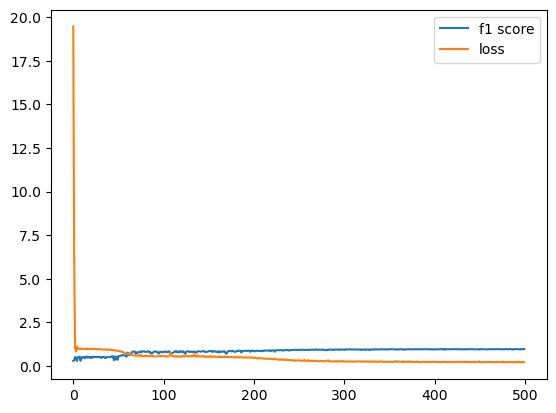

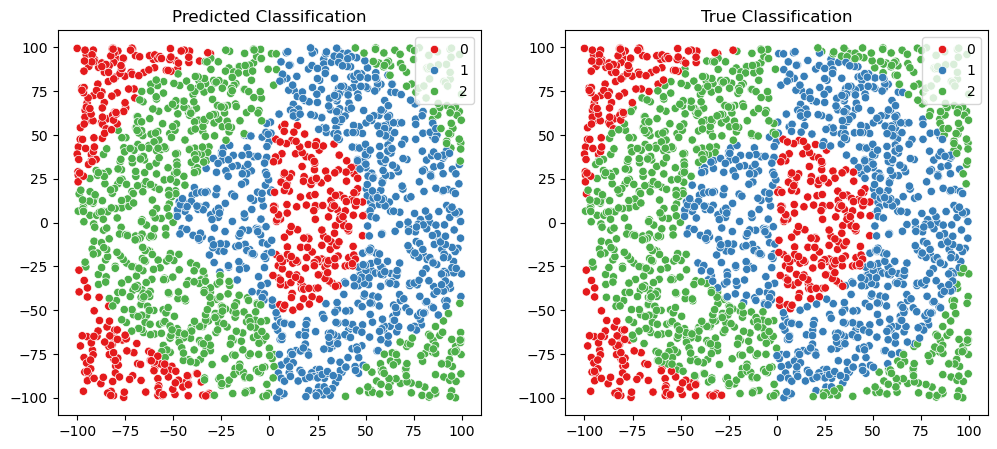

In [10]:
network_rings = network(architecture = np.array([2, 64, 64, 3]), 
                        activation_functions = [None, sigmoid, sigmoid, linear], 
                        activation_derivatives = [None, sigmoid_derivative, sigmoid_derivative, linear_derivative], 
                        initiation_method = 'xavier')

network_rings.learn(task = 'classification',
                     x = [rings_train_X, rings_train_Y],
                     y = rings_train_C,
                     epochs_number = 500,
                     step = 0.1,
                     momentum_dumping = 0.9,
                     batch_size = 150)

print('Final f1_score: ', network_rings.f1_score[-1])
print('Final loss score: ', network_rings.loss_record[-1])
sns.lineplot(network_rings.f1_score, label = 'f1 score')
sns.lineplot(network_rings.loss_record, label = 'loss')

test_classification([rings_test_X, rings_test_Y], rings_test_C, network_rings)

Final f1_score:  0.9599942391200638
Final loss score:  0.18915965890649056
test cross entropy: 0.2732821004497216
test f-measure: 0.8784755978499158


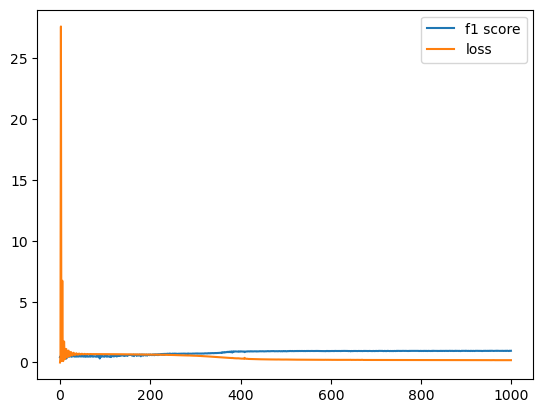

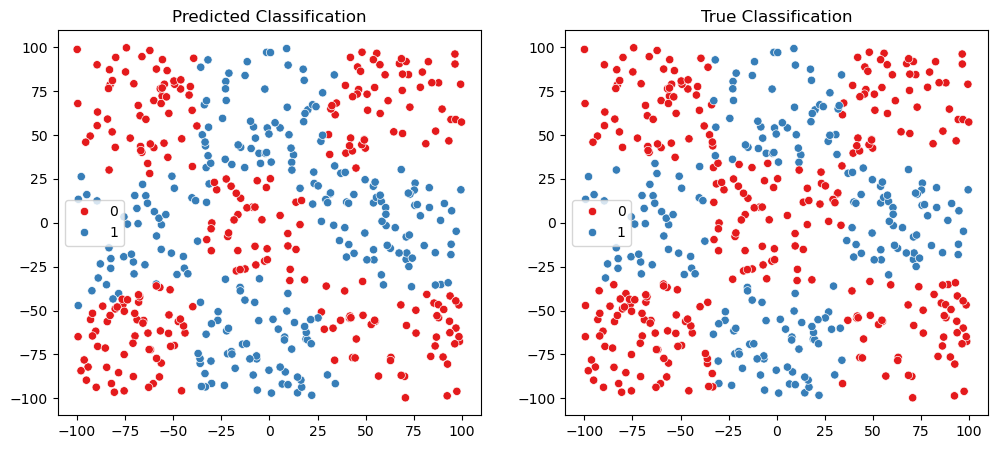

In [8]:
network_xor3 = network(architecture = np.array([2, 30, 30, 2]), 
                        activation_functions = [None, sigmoid, sigmoid, linear], 
                        activation_derivatives = [None, sigmoid_derivative, sigmoid_derivative, linear_derivative], 
                        initiation_method = 'xavier')

network_xor3.learn(task = 'classification',
                     x = [xor3_train_X, xor3_train_Y],
                     y = xor3_train_C,
                     epochs_number = 1000,
                     step = 0.05,
                     momentum_dumping = 0.95,
                     batch_size = 200)

print('Final f1_score: ', network_xor3.f1_score[-1])
print('Final loss score: ', network_xor3.loss_record[-1])
sns.lineplot(network_xor3.f1_score, label = 'f1 score')
sns.lineplot(network_xor3.loss_record, label = 'loss')

test_classification([xor3_test_X, xor3_test_Y], xor3_test_C, network_xor3)